In [1]:
import logging
import random
import copy

import fire
import fwrench.embeddings as feats
import fwrench.utils.autows as autows
import fwrench.utils.data_settings as settings
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from wrench.logging import LoggingHandler

In [2]:
dataset="yelp"
dataset_home="../../datasets"
embedding="raw"  # raw | pca | resnet18 | vae
lf_selector="iws"  # snuba | interactive | goggles
em_hard_labels=False  # Use hard or soft labels for end model training
n_labeled_points=100  # Number of points used to train lf_selector
#
extract_fn = "bert"
lf_class_options="default"  # default | comma separated list of lf classes to use in the selection procedure. Example: 'DecisionTreeClassifier,LogisticRegression'
#
# Interactive Weak Supervision options
iws_iterations=25
iws_cardinality=1
seed=123
prompt=None
iws_auto = True

In [3]:
random.seed(seed)
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)
logger = logging.getLogger(__name__)
device = torch.device("cuda")

In [4]:
train_data, valid_data, test_data, k_cls, model = settings.get_yelp(
                n_labeled_points, dataset_home, extract_fn)

2022-08-15 03:23:41 - loading data from ../../datasets/yelp/train.json


  0%|          | 0/30400 [00:00<?, ?it/s]

2022-08-15 03:23:41 - loading data from ../../datasets/yelp/valid.json


  0%|          | 0/3800 [00:00<?, ?it/s]

2022-08-15 03:23:41 - loading data from ../../datasets/yelp/test.json


  0%|          | 0/3800 [00:00<?, ?it/s]

2022-08-15 03:23:41 - loading features from ../../datasets/yelp/train_bert.pkl
2022-08-15 03:23:41 - loading features from ../../datasets/yelp/valid_bert.pkl
2022-08-15 03:23:41 - loading features from ../../datasets/yelp/test_bert.pkl


In [5]:
embedder = feats.FlattenEmbedding()
embedder.fit(train_data, valid_data, test_data)
train_data_embed = embedder.transform(train_data)
valid_data_embed = embedder.transform(valid_data)
test_data_embed = embedder.transform(test_data)

In [6]:
iws_usefulness = 0.1
acc_list = []
cov_list = []
while iws_usefulness < 0.95:
    test_covered, hard_labels, soft_labels = autows.run_iws(
            valid_data,
            train_data,
            test_data,
            valid_data_embed,
            train_data_embed,
            test_data_embed,
            iws_cardinality,
            iws_iterations,
            iws_auto,
            iws_usefulness,
            lf_class_options,
            k_cls,
            logger,
    )

    # TODO swtich to test set
    acc = accuracy_score(test_covered.labels, hard_labels)
    cov = float(len(test_covered.labels)) / float(len(test_data.labels))
    logger.info(f"label model train acc:    {acc}")
    logger.info(f"label model coverage:     {cov}")

    ################ TRAIN END MODEL ##########################################
    # model.fit(
    #     dataset_train=train_covered,
    #     y_train=hard_labels if em_hard_labels else soft_labels,
    #     dataset_valid=valid_data,
    #     evaluation_step=50,
    #     metric="acc",
    #     patience=1000,
    #     device=device,
    # )
    # logger.info(f"---LeNet eval---")
    # acc = model.test(test_data, "acc")
    # logger.info(f"end model (LeNet) test acc:    {acc}")
    ################ PROFIT 🤑 #################################################
    acc_list.append(acc)
    cov_list.append(cov)
    print(acc, cov)
    iws_usefulness += 0.1

2022-08-15 03:23:43 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.1
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 638.59epoch/s]


2022-08-15 03:26:20 - [0.19875331 0.83048558]
2022-08-15 03:26:20 - [train] accuracy: 0.5240, coverage: 0.9462
2022-08-15 03:26:20 - [0.175 0.74 ]
2022-08-15 03:26:20 - [valid] accuracy: 0.4889, coverage: 0.9000
2022-08-15 03:26:20 - [0.18067227 0.84749232]
2022-08-15 03:26:20 - [test] accuracy: 0.5406, coverage: 0.9526
2022-08-15 03:26:20 - label model train acc:    0.5406077348066298
2022-08-15 03:26:20 - label model coverage:     0.9526315789473684
0.5406077348066298 0.9526315789473684
2022-08-15 03:26:20 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.2
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 368.59epoch/s]


2022-08-15 03:29:49 - [0.18229883 0.83869221]
2022-08-15 03:29:49 - [train] accuracy: 0.5216, coverage: 0.9401
2022-08-15 03:29:49 - [0.15384615 0.75510204]
2022-08-15 03:29:49 - [valid] accuracy: 0.4886, coverage: 0.8800
2022-08-15 03:29:50 - [0.16879174 0.85538462]
2022-08-15 03:29:50 - [test] accuracy: 0.5410, coverage: 0.9466
2022-08-15 03:29:50 - label model train acc:    0.5410063942174034
2022-08-15 03:29:50 - label model coverage:     0.9465789473684211
0.5410063942174034 0.9465789473684211
2022-08-15 03:29:50 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.30000000000000004
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 469.44epoch/s]


2022-08-15 03:33:08 - [0.2684331  0.79885868]
2022-08-15 03:33:08 - [train] accuracy: 0.5380, coverage: 0.9642
2022-08-15 03:33:08 - [0.30952381 0.75510204]
2022-08-15 03:33:08 - [valid] accuracy: 0.5495, coverage: 0.9100
2022-08-15 03:33:08 - [0.25507246 0.82063008]
2022-08-15 03:33:08 - [test] accuracy: 0.5565, coverage: 0.9718
2022-08-15 03:33:08 - label model train acc:    0.5564581640942323
2022-08-15 03:33:08 - label model coverage:     0.9718421052631578
0.5564581640942323 0.9718421052631578
2022-08-15 03:33:08 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.4
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 394.57epoch/s]


2022-08-15 03:36:30 - [0.16567532 0.86012187]
2022-08-15 03:36:30 - [train] accuracy: 0.5249, coverage: 0.9393
2022-08-15 03:36:30 - [0.12820513 0.73469388]
2022-08-15 03:36:30 - [valid] accuracy: 0.4659, coverage: 0.8800
2022-08-15 03:36:30 - [0.15497254 0.8871216 ]
2022-08-15 03:36:30 - [test] accuracy: 0.5527, coverage: 0.9442
2022-08-15 03:36:30 - label model train acc:    0.552675585284281
2022-08-15 03:36:30 - label model coverage:     0.9442105263157895
0.552675585284281 0.9442105263157895
2022-08-15 03:36:30 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.5
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 361.27epoch/s]


2022-08-15 03:39:59 - [0.21060943 0.80731032]
2022-08-15 03:39:59 - [train] accuracy: 0.5180, coverage: 0.9451
2022-08-15 03:39:59 - [0.225 0.74 ]
2022-08-15 03:39:59 - [valid] accuracy: 0.5111, coverage: 0.9000
2022-08-15 03:39:59 - [0.19147659 0.82762148]
2022-08-15 03:39:59 - [test] accuracy: 0.5349, coverage: 0.9529
2022-08-15 03:39:59 - label model train acc:    0.5349351008008837
2022-08-15 03:39:59 - label model coverage:     0.9528947368421052
0.5349351008008837 0.9528947368421052
2022-08-15 03:39:59 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.6
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 426.40epoch/s]


2022-08-15 03:43:50 - [0.19538163 0.83609216]
2022-08-15 03:43:50 - [train] accuracy: 0.5258, coverage: 0.9441
2022-08-15 03:43:50 - [0.175 0.76 ]
2022-08-15 03:43:50 - [valid] accuracy: 0.5000, coverage: 0.9000
2022-08-15 03:43:50 - [0.1796875 0.8567042]
2022-08-15 03:43:50 - [test] accuracy: 0.5453, coverage: 0.9521
2022-08-15 03:43:50 - label model train acc:    0.5453289110005528
2022-08-15 03:43:50 - label model coverage:     0.9521052631578948
0.5453289110005528 0.9521052631578948
2022-08-15 03:43:50 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.7
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 429.21epoch/s]


2022-08-15 03:47:11 - [0.18682114 0.83408952]
2022-08-15 03:47:11 - [train] accuracy: 0.5213, coverage: 0.9400
2022-08-15 03:47:11 - [0.15384615 0.75510204]
2022-08-15 03:47:11 - [valid] accuracy: 0.4886, coverage: 0.8800
2022-08-15 03:47:11 - [0.17283202 0.85069266]
2022-08-15 03:47:11 - [test] accuracy: 0.5400, coverage: 0.9468
2022-08-15 03:47:11 - label model train acc:    0.5400222345747637
2022-08-15 03:47:11 - label model coverage:     0.9468421052631579
0.5400222345747637 0.9468421052631579
2022-08-15 03:47:11 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.7999999999999999
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 456.95epoch/s]


2022-08-15 03:50:37 - [0.02757635 0.96988211]
2022-08-15 03:50:37 - [train] accuracy: 0.5390, coverage: 0.7043
2022-08-15 03:50:37 - [0.09090909 0.90243902]
2022-08-15 03:50:37 - [valid] accuracy: 0.6190, coverage: 0.6300
2022-08-15 03:50:38 - [0.02738589 0.97638285]
2022-08-15 03:50:38 - [test] accuracy: 0.5700, coverage: 0.7405
2022-08-15 03:50:38 - label model train acc:    0.5700071073205402
2022-08-15 03:50:38 - label model coverage:     0.7405263157894737
0.5700071073205402 0.7405263157894737
2022-08-15 03:50:38 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.8999999999999999
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 746.26epoch/s]


2022-08-15 03:53:57 - [0. 1.]
2022-08-15 03:53:57 - [train] accuracy: 0.5610, coverage: 0.3332
2022-08-15 03:53:57 - [0. 1.]
2022-08-15 03:53:57 - [valid] accuracy: 0.8095, coverage: 0.2100
2022-08-15 03:53:57 - [0. 1.]
2022-08-15 03:53:57 - [test] accuracy: 0.5782, coverage: 0.3600
2022-08-15 03:53:57 - label model train acc:    0.5782163742690059
2022-08-15 03:53:57 - label model coverage:     0.36
0.5782163742690059 0.36
2022-08-15 03:53:57 - Using LF classes: [functools.partial(<class 'sklearn.tree._classes.DecisionTreeClassifier'>, max_depth=1), <class 'sklearn.linear_model._logistic.LogisticRegression'>]
the shape of x_val is: (100, 768)
current usefulness is : 0.9999999999999999
|----------------------------------------------------------------------------------------------------|0.0% 0/255

/hdd2/kaylee/AutoWS-Bench-101/fwrench/lf_selectors/interactive/utils.py:683: RuntimeWarning: invalid value encountered in true_divide
  accuracy = (tp + tn) / numvotes


|████████████████████████████████████████████████████████████████████████████████████████████████████|100.0% 25/25


100%|██████████| 100/100 [00:00<00:00, 1749.46epoch/s]


2022-08-15 03:57:06 - [0. 1.]
2022-08-15 03:57:06 - [train] accuracy: 0.5341, coverage: 0.2631
2022-08-15 03:57:06 - [0. 1.]
2022-08-15 03:57:06 - [valid] accuracy: 0.7778, coverage: 0.1800
2022-08-15 03:57:06 - [0. 1.]
2022-08-15 03:57:06 - [test] accuracy: 0.5484, coverage: 0.2879
2022-08-15 03:57:06 - label model train acc:    0.5484460694698354
2022-08-15 03:57:06 - label model coverage:     0.28789473684210526
0.5484460694698354 0.28789473684210526


In [11]:
with open('yelp_acc_file_1.txt', 'w') as f:
        for line in acc_list:
            f.write(f"{line}\n")
with open('yelp_cov_file_1.txt', 'w') as f:
    for line in cov_list:
        f.write(f"{line}\n")


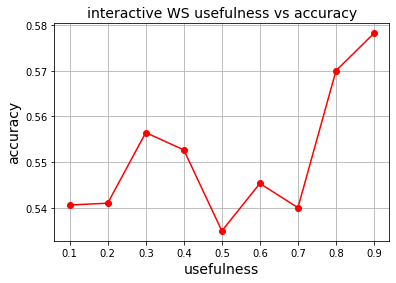

In [9]:
a= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
import matplotlib.pyplot as plt

plt.plot(a, acc_list, color='red', marker='o')
plt.title('interactive WS usefulness vs accuracy', fontsize=14)
plt.xlabel('usefulness', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.grid(True)
plt.show()


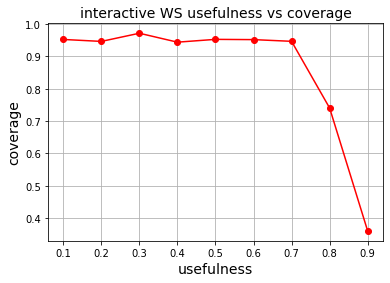

In [10]:
plt.plot(a, cov_list, color='red', marker='o')
plt.title('interactive WS usefulness vs coverage', fontsize=14)
plt.xlabel('usefulness', fontsize=14)
plt.ylabel('coverage', fontsize=14)
plt.grid(True)
plt.show()

In [6]:
with open("yelp_acc_file_0.txt", "r") as file:
    acc_list=file.read().splitlines()
acc_list = list(map(float, acc_list))

with open("yelp_cov_file_0.txt", "r") as file:
    cov_list=file.read().splitlines()
cov_list = list(map(float, cov_list))

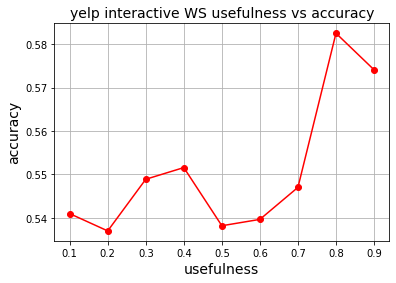

In [7]:
a= [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
import matplotlib.pyplot as plt

plt.plot(a, acc_list, color='red', marker='o')
plt.title('yelp interactive WS usefulness vs accuracy', fontsize=14)
plt.xlabel('usefulness', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.grid(True)
plt.show()


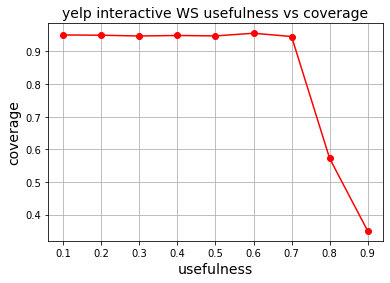

In [8]:
plt.plot(a, cov_list, color='red', marker='o')
plt.title('yelp interactive WS usefulness vs coverage', fontsize=14)
plt.xlabel('usefulness', fontsize=14)
plt.ylabel('coverage', fontsize=14)
plt.grid(True)
plt.show()